In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import analyze_utils
import dvu
dvu.set_style()
cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

In [2]:
from typing import Dict
import pickle

# load suffix stuff
suffix_results = pickle.load(open('../results/prompt_gen/results_suffix_anli.pkl', 'rb'))
SUFFIX_LEGEND_REMAP = {
    'Single-query': 'Suffix, single-output decoding',
    'Avg suffix': 'Suffix, average-output decoding',
}
suffix_results['legend'] = suffix_results['use_single_query'].map(
            SUFFIX_LEGEND_REMAP) + ' (' + suffix_results['n_shots'].astype(str) + '-Ex.)'
suffix_results['do_reranking'] = False
suffix_results['reciprocal_rank'] = suffix_results['final_answer_pos_initial_token'].map(lambda n: 1/(n+1))

# import prefix stuff
prefix_results = pickle.load(open('/home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan_3/anli/r.pkl', 'rb'))
# prefix_results = pickle.load(open('/home/chansingh/mntv1/jack_prefix_math_9_15/r.pkl', 'rb'))

def make_legend__prefix(table_row: Dict) -> str:
    single_query_str = {
        0: 'average',
        1: 'single'
    }[table_row['single_query']]
    rerank_str = {
        0: '',
        1: ' with reranking'
    }[table_row['do_reranking']]
    
    return 'Prefix, ' + single_query_str + '-output' + rerank_str + f' ({table_row["n_shots"]}-Ex.)'

prefix_results['legend'] = prefix_results.apply(make_legend__prefix, axis=1)
prefix_results = prefix_results.rename(columns={'single_query': 'use_single_query'})

In [3]:
def replace_max_rank(num: int, max_val: int = 10_000) -> int:
    if (num > max_val) or (pd.isna(num)):
        return max_val
    return num
    
prefix_results['final_answer_pos_initial_token'] = prefix_results['final_answer_pos_initial_token'].map(replace_max_rank)
prefix_results = analyze_utils.postprocess_results(prefix_results)
prefix_results['reciprocal_rank'] = prefix_results['final_answer_pos_initial_token'].map(lambda n: 1/(n+1))

In [4]:
list(prefix_results['legend'].unique())

['Prefix, average-output (5-Ex.)',
 'Prefix, single-output with reranking (1-Ex.)',
 'Prefix, single-output (1-Ex.)',
 'Prefix, single-output (5-Ex.)',
 'Prefix, average-output with reranking (1-Ex.)',
 'Prefix, average-output with reranking (5-Ex.)',
 'Prefix, average-output (1-Ex.)']

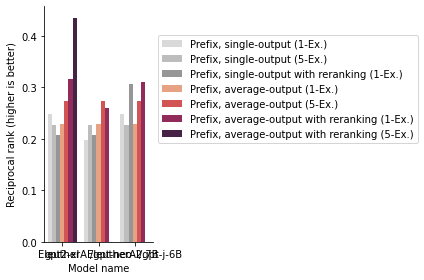

In [5]:
# metric_key = 'final_answer_pos_initial_token'
# metric_key = f'Recall @ {5} suffixes'
metric_key = 'reciprocal_rank'
tab = (
    (prefix_results
        # (mean over templates, task_name)
        .groupby(['checkpoint', 'n_shots', 'do_reranking', 'use_single_query', 'legend'])[[metric_key]]
        .mean()
        .reset_index()
    )
)
analyze_utils.plot_tab(tab, metric_key=metric_key, title='ANLI datasets', add_legend=False)

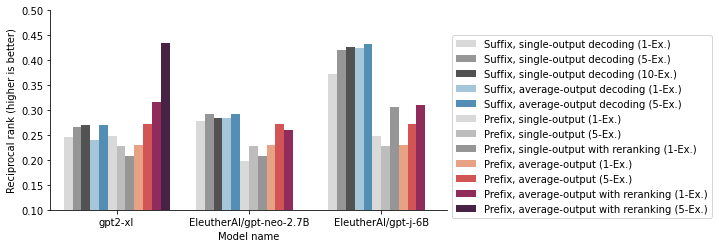

In [6]:
r = pd.concat((prefix_results, suffix_results), axis=0)

for metric_key in [
                'reciprocal_rank',
                # 'final_answer_pos_initial_token',
                #  f'Recall @ {3} suffixes',
                #    f'Recall @ {10} suffixes', 
                #    f'Recall @ {100} suffixes',
                   ]:
    plt.figure(figsize=(10, 3.5))
    tab = ((r
            # (mean over templates, task_name)
            .groupby(['checkpoint', 'n_shots', 'do_reranking', 'use_single_query', 'legend'])[[metric_key]]
            .mean()
            .reset_index()
        )
    )
    analyze_utils.plot_tab(tab, metric_key=metric_key, title='ANLI datasets', add_legend=False)
    plt.ylim((0.1, 0.5))
    if metric_key == 'reciprocal_rank':
        plt.savefig('../results/prompt_gen/joint_anli_barplot.pdf', bbox_inches='tight')
        tab.to_pickle(f'../results/prompt_gen/tab_joint_anli_{metric_key}.pkl')
    # plt.legend('', frameon=False)
    plt.show()

<AxesSubplot:xlabel='task_name', ylabel='final_answer_pos_initial_token'>

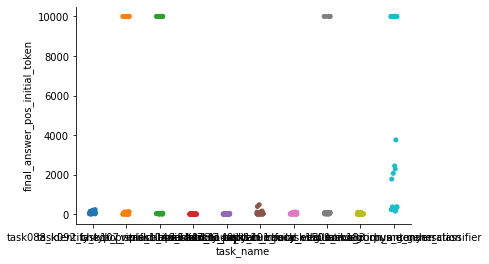

In [7]:
rr_results = ((r
        # (mean over templates, task_name)
        .groupby(['task_name', 'checkpoint', 'n_shots', 'do_reranking', 'use_single_query', 'legend'])[['final_answer_pos_initial_token']]
        .mean()
        .reset_index()
    )
)
# rr_results.groupby(['checkpoint', 'n_shots']).count()
sns.stripplot(data=rr_results, x='task_name', y='final_answer_pos_initial_token')

### Plot the best model

In [8]:
r['legend'].value_counts()

Prefix, single-output with reranking (1-Ex.)     3840
Prefix, single-output (1-Ex.)                    3840
Prefix, single-output (5-Ex.)                    3840
Prefix, average-output with reranking (1-Ex.)    3840
Prefix, average-output (1-Ex.)                   3840
Prefix, average-output (5-Ex.)                   3456
Prefix, average-output with reranking (5-Ex.)     896
Suffix, single-output decoding (1-Ex.)             90
Suffix, single-output decoding (5-Ex.)             90
Suffix, single-output decoding (10-Ex.)            90
Suffix, average-output decoding (1-Ex.)            30
Suffix, average-output decoding (5-Ex.)            30
Name: legend, dtype: int64

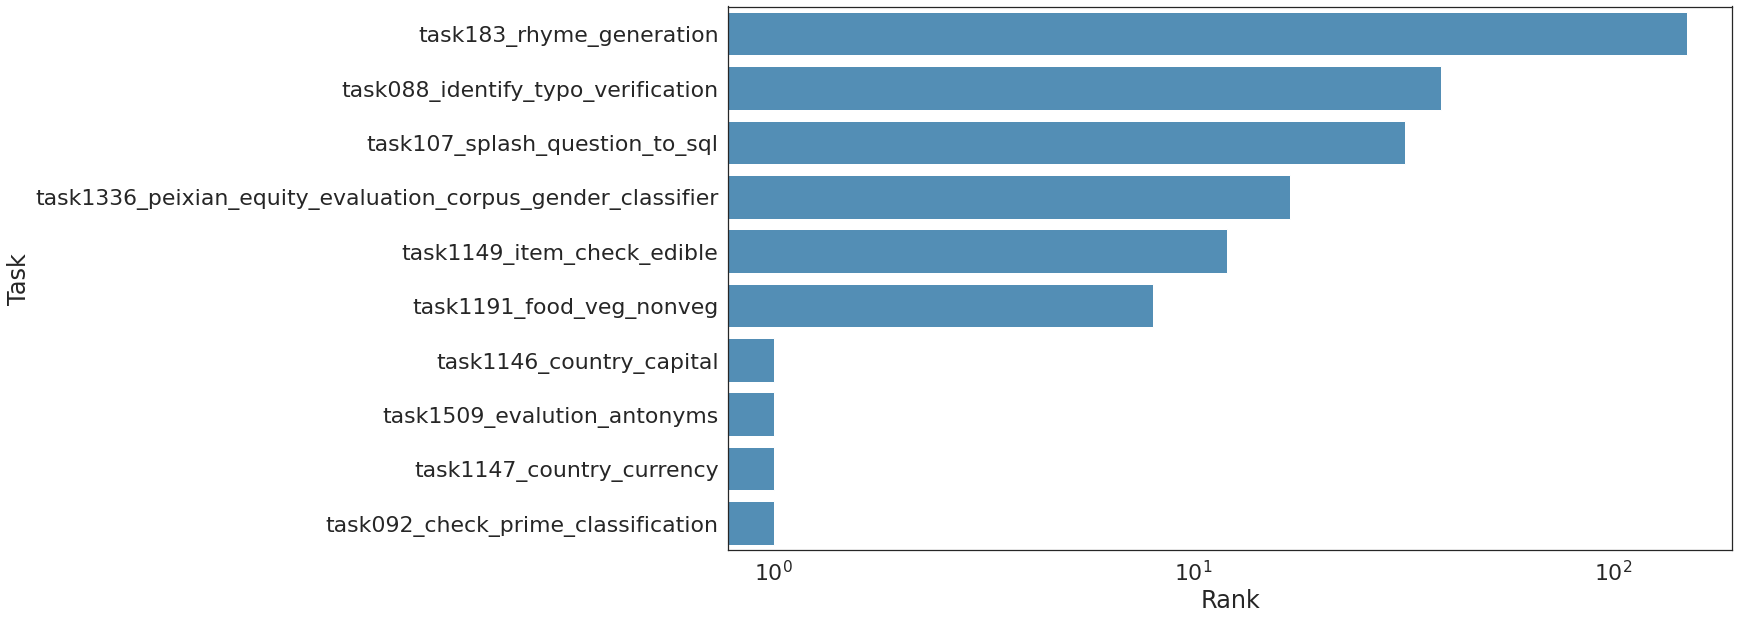

In [10]:
r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_model(legend_name: str):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(18,10))
    model_results = (
        r[(r['legend'] == legend_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            .sort_values(by='rank', ascending=False)
    )
    sns.barplot(data=model_results, y='task_name', x='rank', color=analyze_utils.COLORS[legend_name])
    plt.gca().set_xscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Task')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='Suffix, average-output decoding (5-Ex.)')

In [11]:
r['task_name'].unique()

array(['task1191_food_veg_nonveg', 'task1509_evalution_antonyms',
       'task1147_country_currency', 'task088_identify_typo_verification',
       'task1146_country_capital', 'task183_rhyme_generation',
       'task107_splash_question_to_sql',
       'task1336_peixian_equity_evaluation_corpus_gender_classifier',
       'task092_check_prime_classification', 'task1149_item_check_edible'],
      dtype=object)

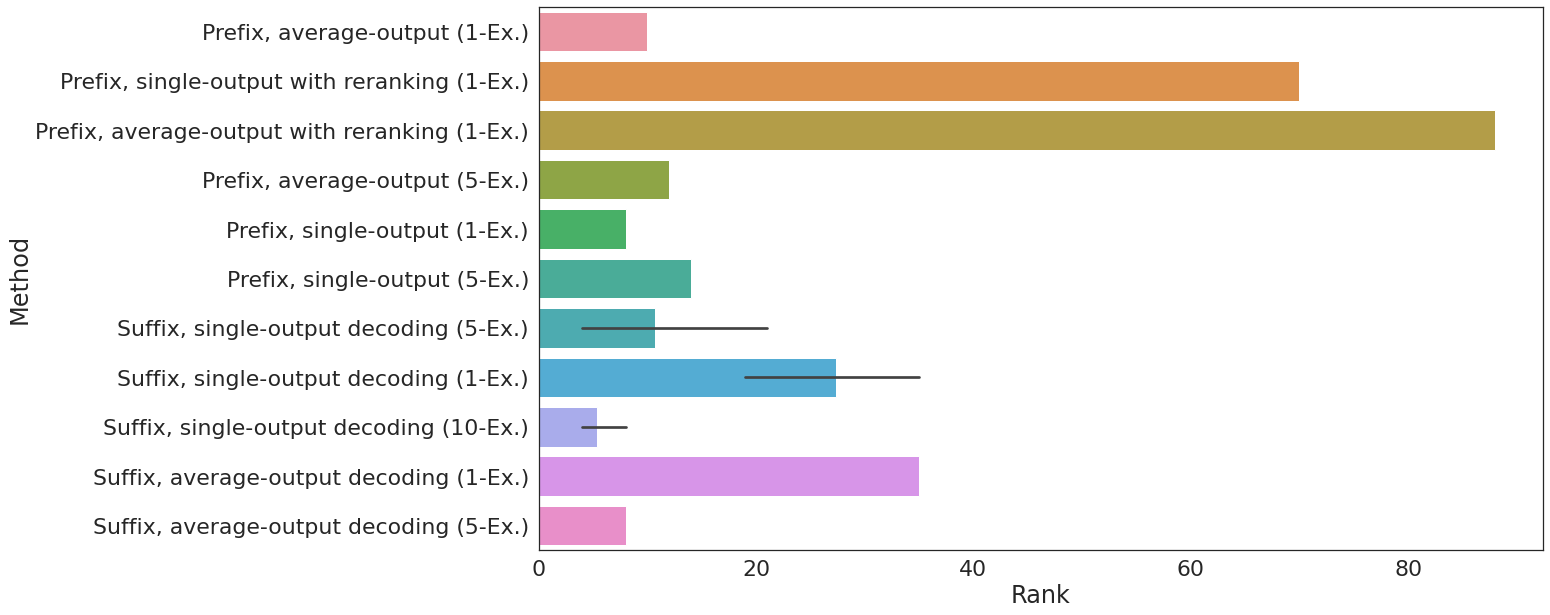

In [12]:
r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_task(task_name: str):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(18,10))
    model_results = (
        r[(r['task_name'] == task_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            # .sort_values(by='rank', ascending=False)
    )
    model_results['color'] = model_results['legend'].map(analyze_utils.COLORS.get)
    # print(model_results['color'])
    sns.barplot(data=model_results, y='legend', x='rank')
    # plt.gca().set_xscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Method')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_task(task_name='task1191_food_veg_nonveg')

In [ ]:
def drop_non_unique_cols(df: pd.DataFrame) -> pd.DataFrame:
    # df = df.reset_index()
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    return df.drop(cols_to_drop, axis=1)
    
drop_non_unique_cols(
    r[(r['task_name'] == 'task1191_food_veg_nonveg') & (r['checkpoint'] == 'EleutherAI/gpt-j-6B') & (r['legend'] == 'Suffix, single-output decoding (1-Ex.)')].reset_index()
        .sort_values(by='rank', ascending=False)
)